In [2]:
library(DT)
library(patchwork)
library(igraph)
library(dplyr)
library(ggalluvial)
library(CellChat)
library(Seurat)
library(SeuratDisk)
library(patchwork)
library(pheatmap)

library(Seurat)

library(dplyr)
library(ggplot2)
library(dior)
library(Matrix)
library(rhdf5)
library(reticulate)
suppressWarnings(suppressMessages(future::plan("multiprocess", workers = 8)))

In [3]:
ad <- import("anndata", convert = FALSE)
ad_object <- ad$read_h5ad("../data/v4-naf.h5ad")

In [4]:
ad_object$X

<18135x30901 sparse matrix of type '<class 'numpy.float32'>'
	with 51233405 stored elements in Compressed Sparse Row format>

In [6]:
dim(t(py_to_r(ad_object$X)))

[1] 30901 18135

[1] 30901 18135

In [3]:


data.input <- t(py_to_r(ad_object$X))
rownames(data.input) <- rownames(py_to_r(ad_object$var))
colnames(data.input) <- rownames(py_to_r(ad_object$obs))
# access meta data
meta.data <- py_to_r(ad_object$obs)
meta <- meta.data
cellchat <- createCellChat(object = as.matrix(data.input), meta = meta, group.by = "leiden_poly")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.2 GiB”


[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Fib1 Fib2 Fib3 Macro1 Macro2 Macro3 


In [4]:
ad_object

AnnData object with n_obs × n_vars = 18135 × 30901
    obs: 'sample', 'sample_batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample_group', 'new_cls', 'leiden_poly'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [5]:
cellchat <- addMeta(cellchat, meta = meta)

[1] "Fib1"   "Fib2"   "Fib3"   "Macro1" "Macro2" "Macro3"

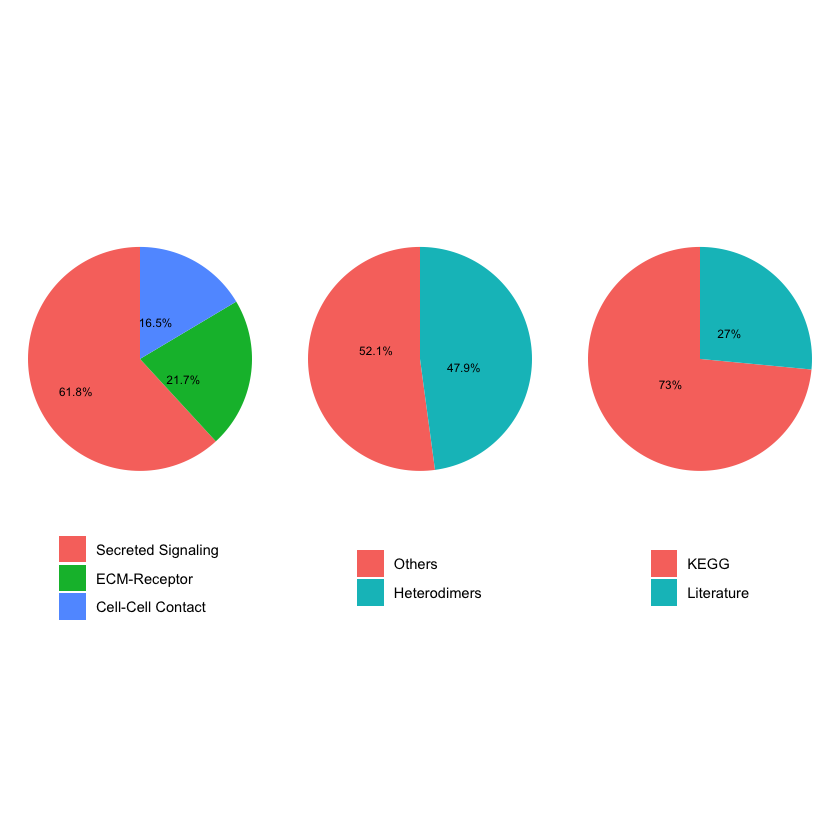

In [6]:
cellchat <- setIdent(cellchat, ident.use = "leiden_poly") # set "labels" as default cell identity
levels(cellchat@idents) # show factor levels of the cell labels
groupSize <- as.numeric(table(cellchat@idents)) # number of cells in each cell group
CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data
showDatabaseCategory(CellChatDB)
# ggsave(filename = './figures/cellchat/showadatabase.pdf', width = 10, height = 10)

In [7]:
# CellChatDB.use <- subsetDB(CellChatDB, search = "Cell-Cell Contact") 

In [8]:
cellchat@DB <- CellChatDB

In [9]:
cellchat <- subsetData(cellchat)
future::plan("multiprocess", workers = 8) 

In [10]:
cellchat

An object of class CellChat created from a single dataset 
 30901 genes.
 18135 cells. 
CellChat analysis of single cell RNA-seq data! 

In [11]:
?computeCommunProbPathway

In [12]:
cellchat <- identifyOverExpressedGenes(cellchat)

In [13]:
cellchat <- identifyOverExpressedInteractions(cellchat)

In [14]:
#project gene expression data onto PPI (Optional: when running it, USER 
#should set `raw.use = FALSE` in the function `computeCommunProb()` in order to use the projected data)
# cellchat <- projectData(cellchat, PPI.human)

In [15]:
cellchat <- computeCommunProb(cellchat)

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2023-05-17 16:43:48]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-05-17 16:45:57]"


In [16]:

# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 100)

In [17]:
cellchat <- computeCommunProbPathway(cellchat)

In [18]:
cellchat <- aggregateNet(cellchat)

In [19]:
groupSize <- as.numeric(table(cellchat@idents))

In [20]:
groupSize

[1] 8433 2242 1296 2286 3078  800

In [21]:
write.table(colSums(cellchat@netP$prob,dims = 2),file = '234.csv',sep = ',')

In [22]:
cellchat@net$count

,Fib1,Fib2,Fib3,Macro1,Macro2,Macro3
Fib1,59,47,16,54,36,103
Fib2,63,60,33,66,55,117
Fib3,44,33,15,43,29,87
Macro1,13,12,8,38,28,48
Macro2,10,7,6,30,21,36
Macro3,60,50,20,76,57,129


In [26]:
pdf('./figures/cellchat/Number of interactions——naf.pdf', width = 10, height = 10, )
netVisual_circle(cellchat@net$count, vertex.weight = groupSize,title.name = "Number of interactions",
                margin =0.2,alpha.edge=0.5,  vertex.label.color = "transparent", edge.width.max = 0.2
                )
dev.off()

ERROR while rich displaying an object: Error in file(con, "rb"): 无法打开链结

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_png.recordedplot(obj)
8. repr_recordedplot_generic(obj, ".png", TRUE

plot without title

null device 
          1

In [22]:
# pdf('./figures/cellchat/Interaction weights.strength_af.pdf', width = 10, height = 10)
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, title.name = "Interaction weights/strength",
                vertex.label.cex=1,margin =0.2,alpha.edge=0.5,    edge.width.max = 2)
# dev.off()

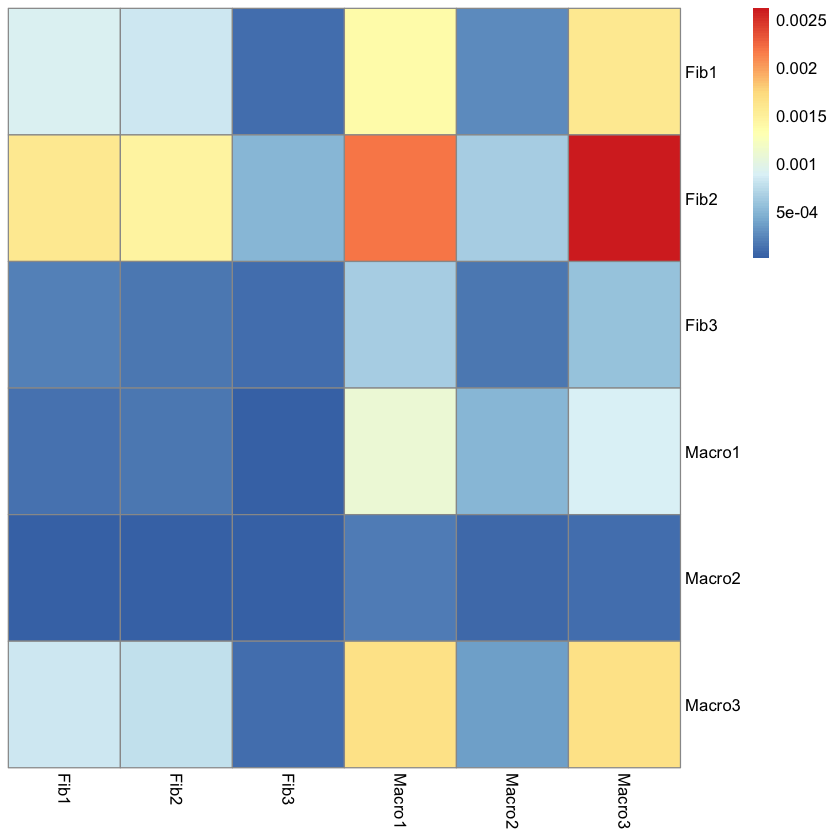

In [47]:
pheatmap(cellchat@net$weight, cluster_rows = FALSE, cluster_cols = FALSE)

In [48]:
write.table(cellchat@netP$prob, file = './figures/cellchat/prob-naf.csv',sep = '\t')

In [49]:
write.table(cellchat@net$count, file = './figures/cellchat/net_count_naf.csv',sep = '\t')

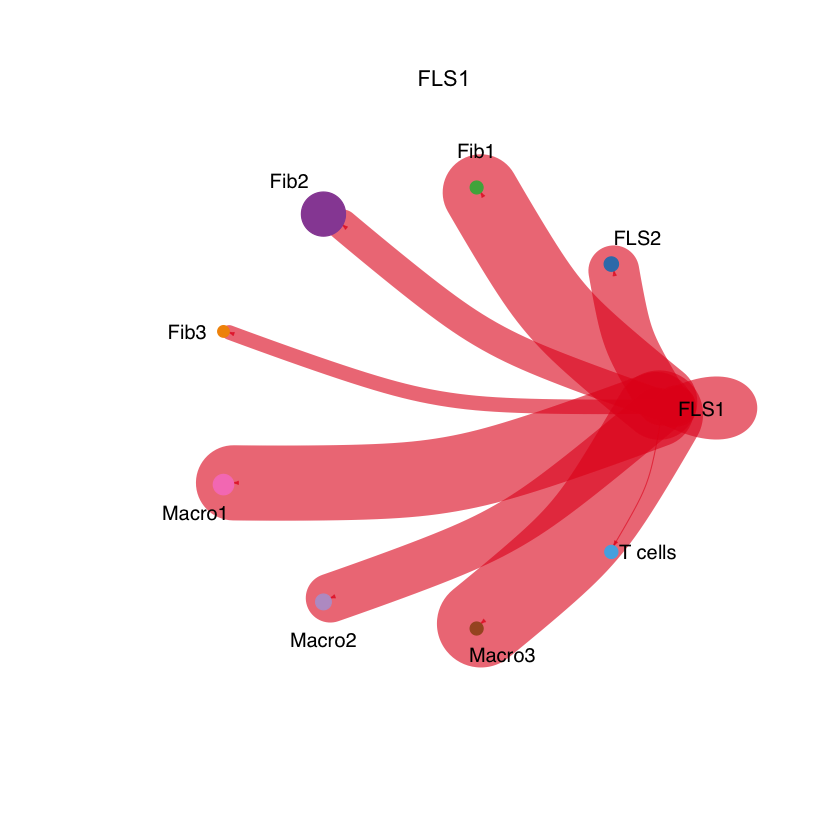

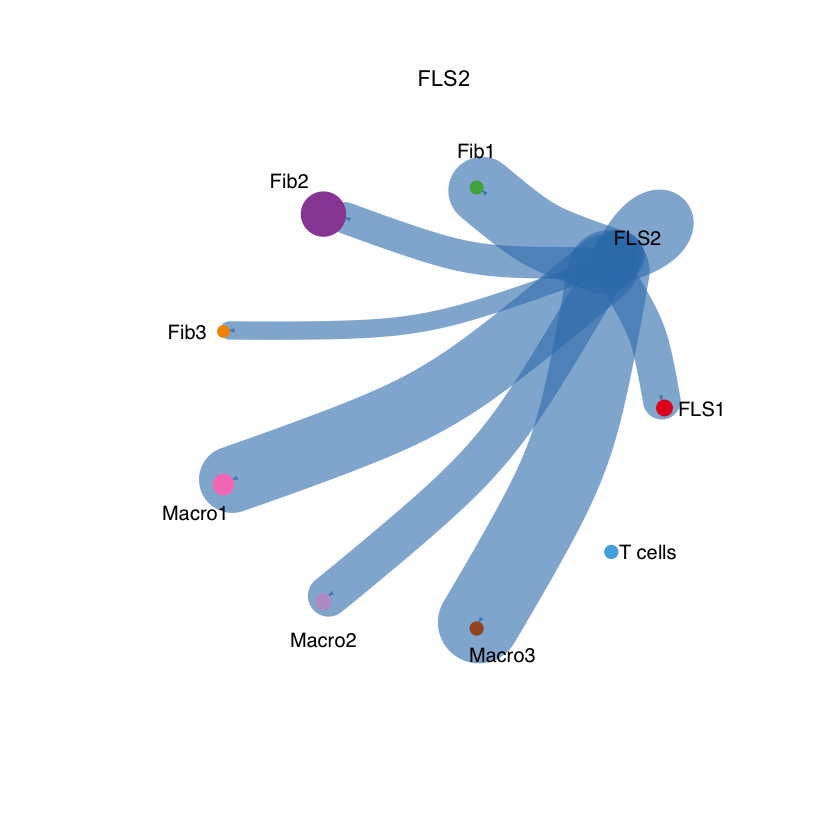

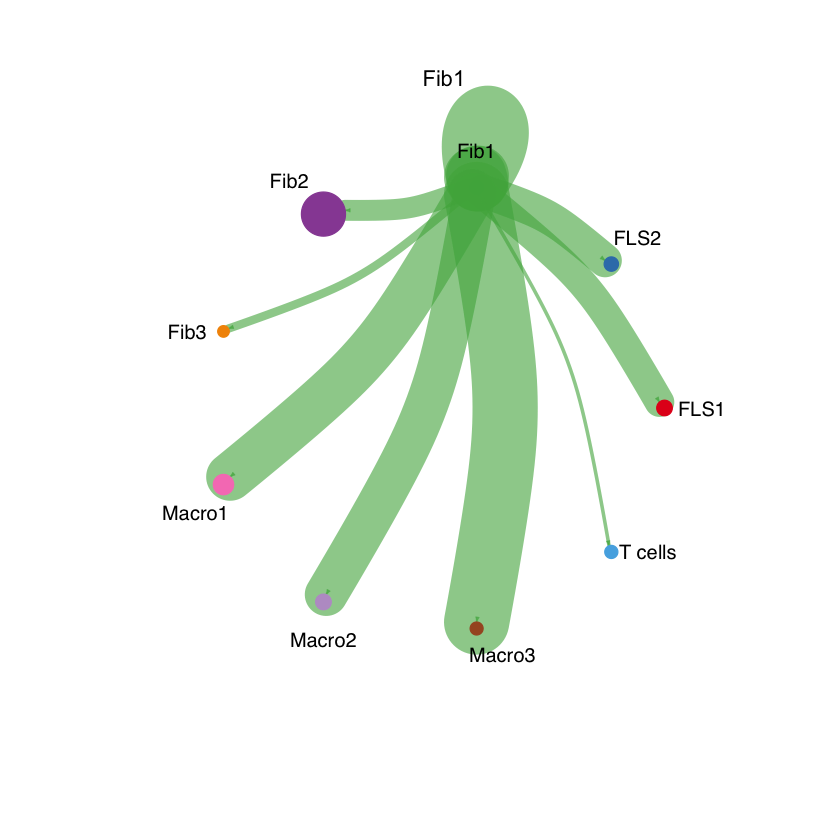

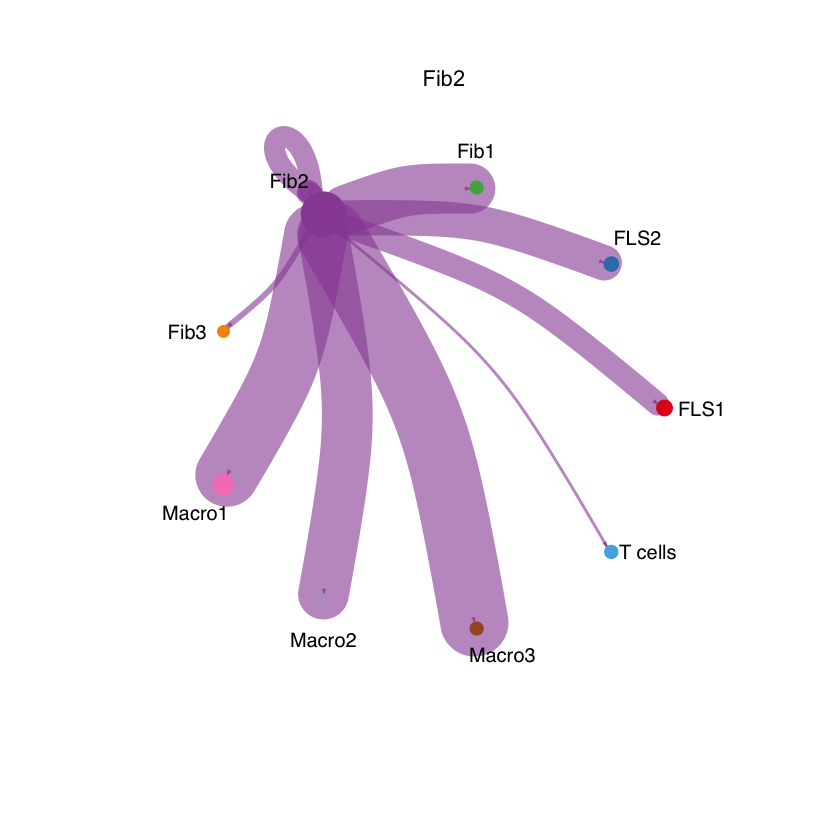

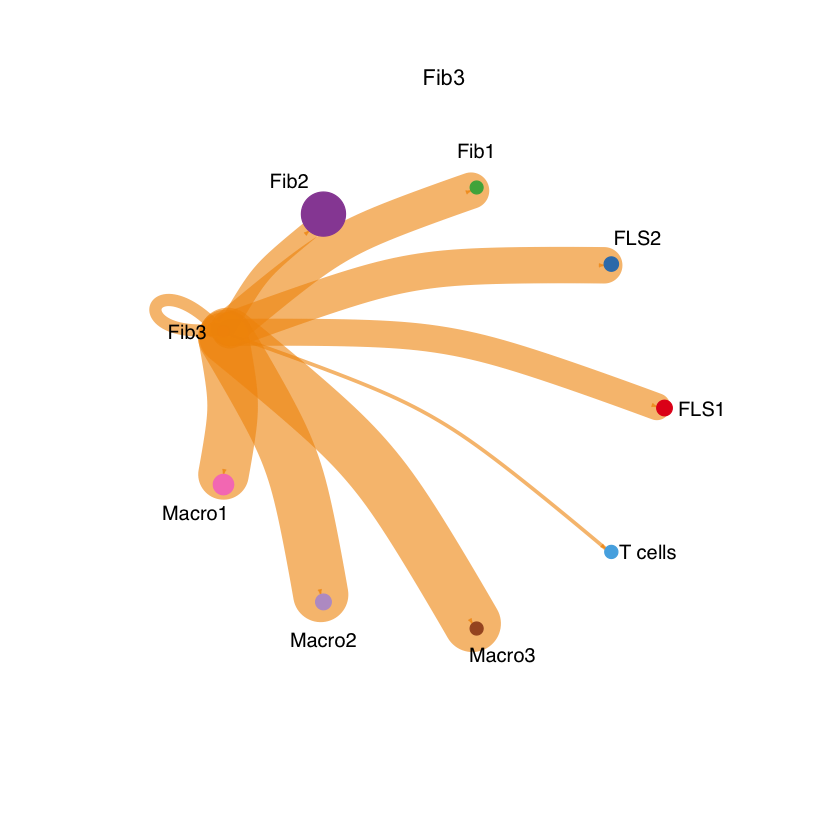

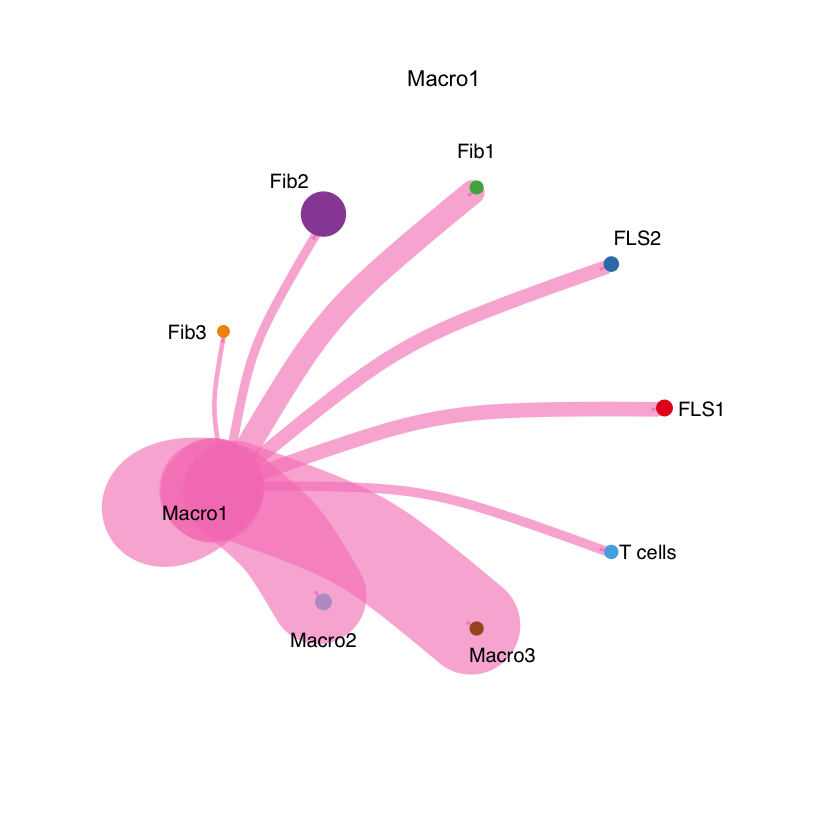

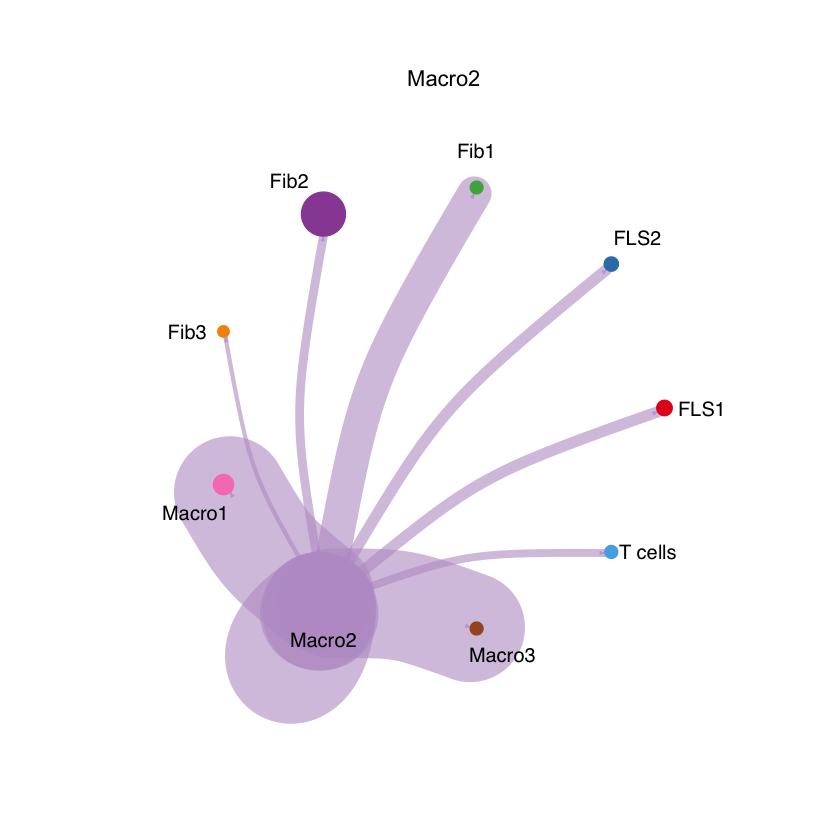

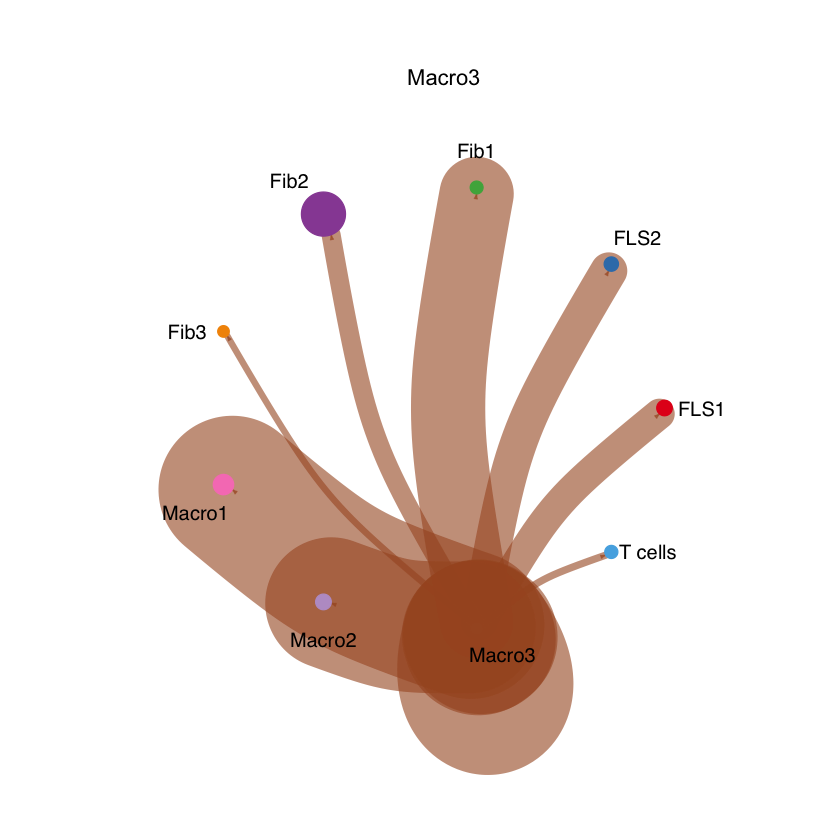

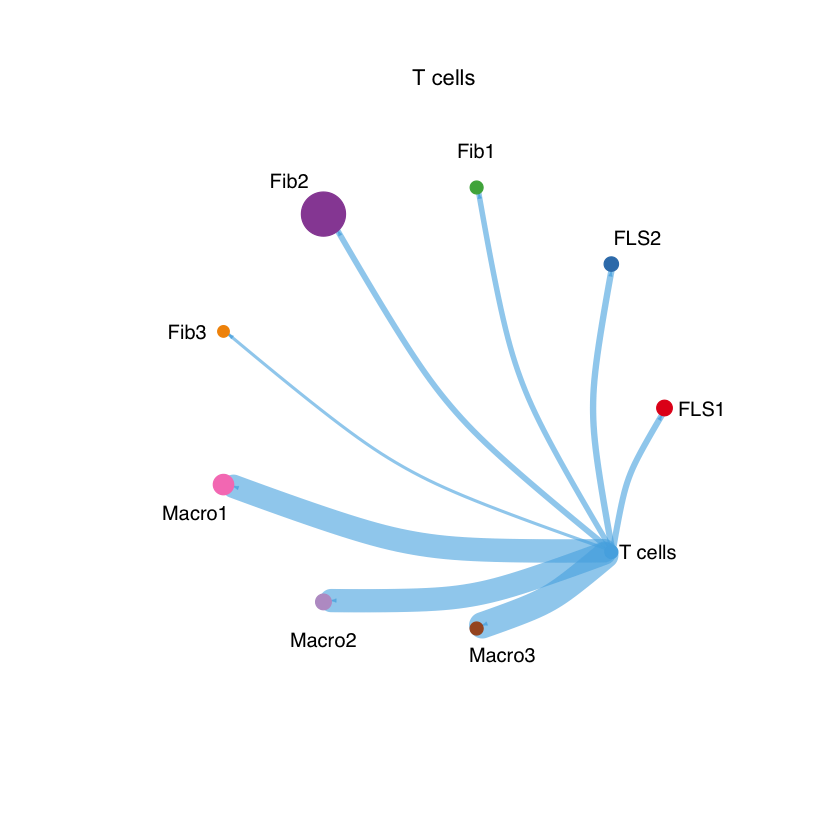

In [23]:
mat <- cellchat@net$weight
par( c(2,2), xpd=TRUE)
for (i in 1:nrow(mat)) {
    mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
    mat2[i, ] <- mat[i, ]
#     name = paste('./figures/cellchat/' ,rownames(mat)[i] ,'isolate_plot_af.pdf')
#     pdf(name, width = 10, height = 10)
    netVisual_circle(mat2, vertex.weight = groupSize,  edge.weight.max = max(mat), title.name = rownames(mat)[i])
#     dev.off()
}

In [24]:
cellchat@netP$pathways

[1] "MHC-II"     "SEMA3"      "ADGRE5"     "ANGPTL"     "LAMININ"   
 [6] "THBS"       "COLLAGEN"   "CXCL"       "EGF"        "PTPRM"     
[11] "GALECTIN"   "GAS"        "THY1"       "IL16"       "CD45"      
[16] "CSF"        "CADM"       "EPHA"       "PDGF"       "PECAM1"    
[21] "COMPLEMENT" "MK"         "ICAM"       "CCL"        "ITGB2"     
[26] "TENASCIN"   "FN1"        "NEGR"       "CHEMERIN"   "PARs"      
[31] "ncWNT"      "HGF"        "NOTCH"      "IGF"        "IL2"

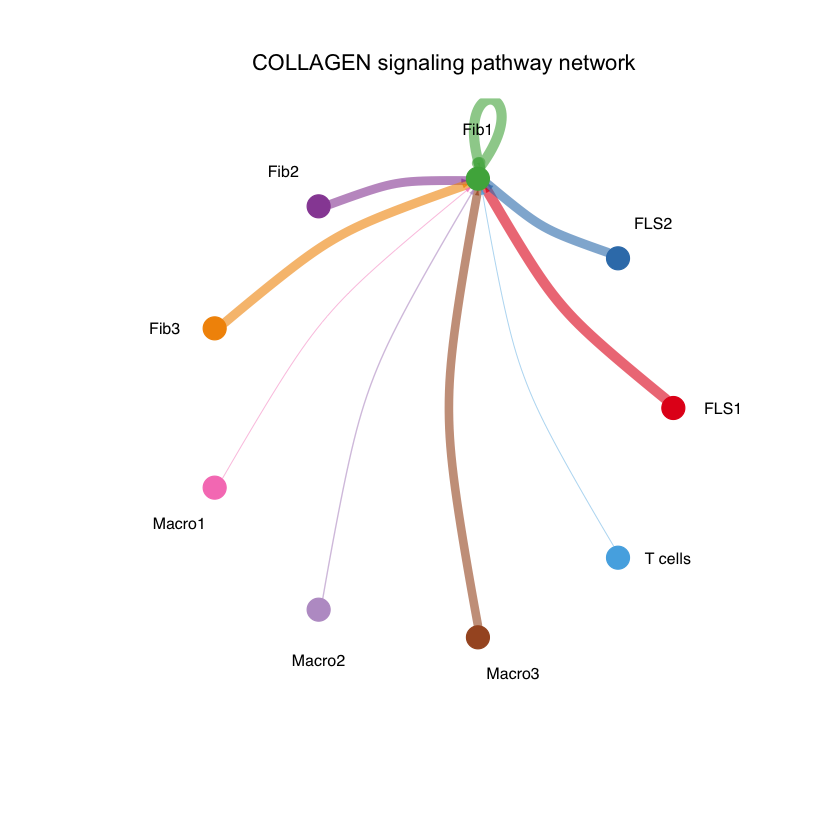

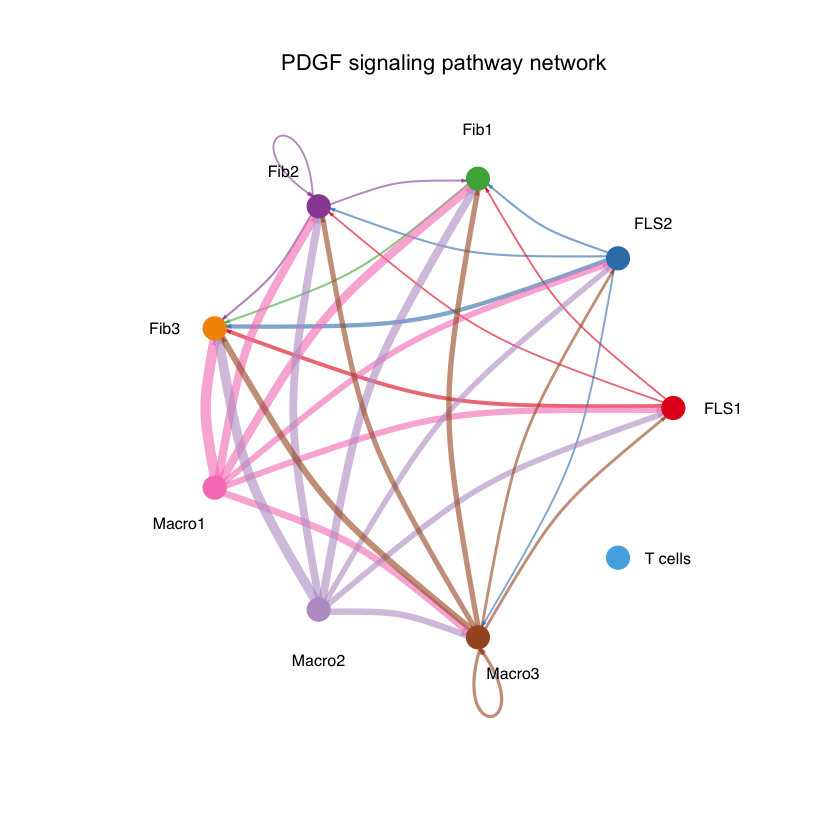

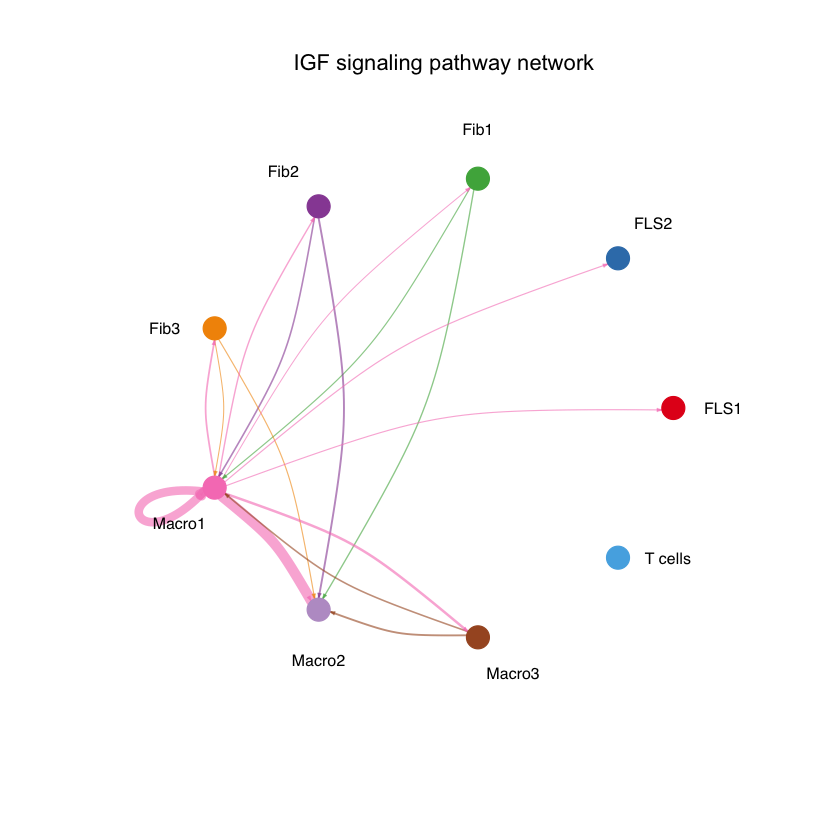

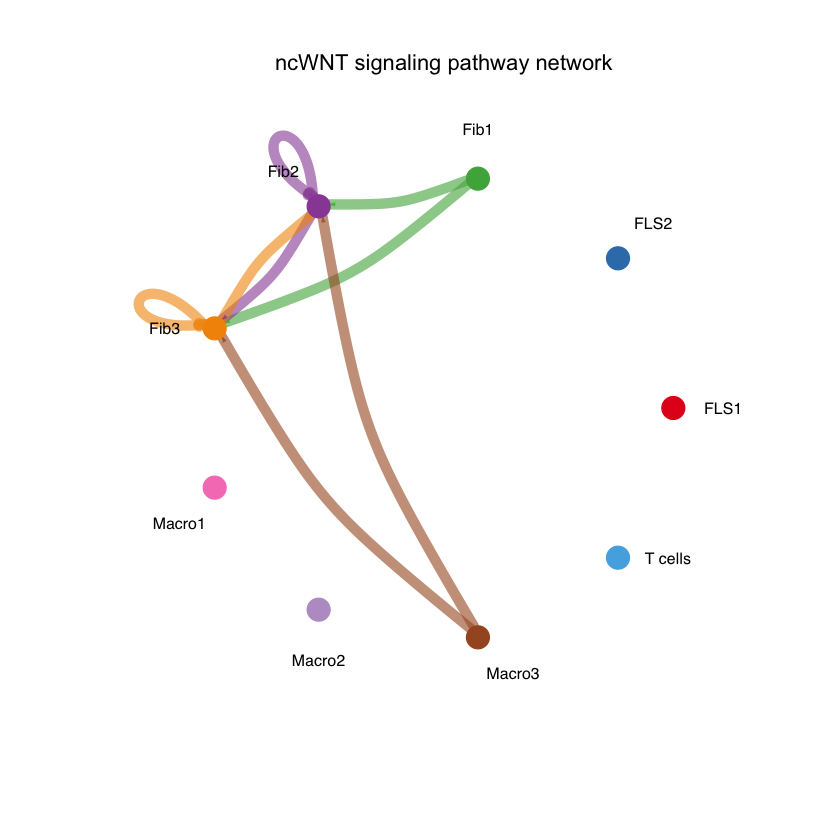

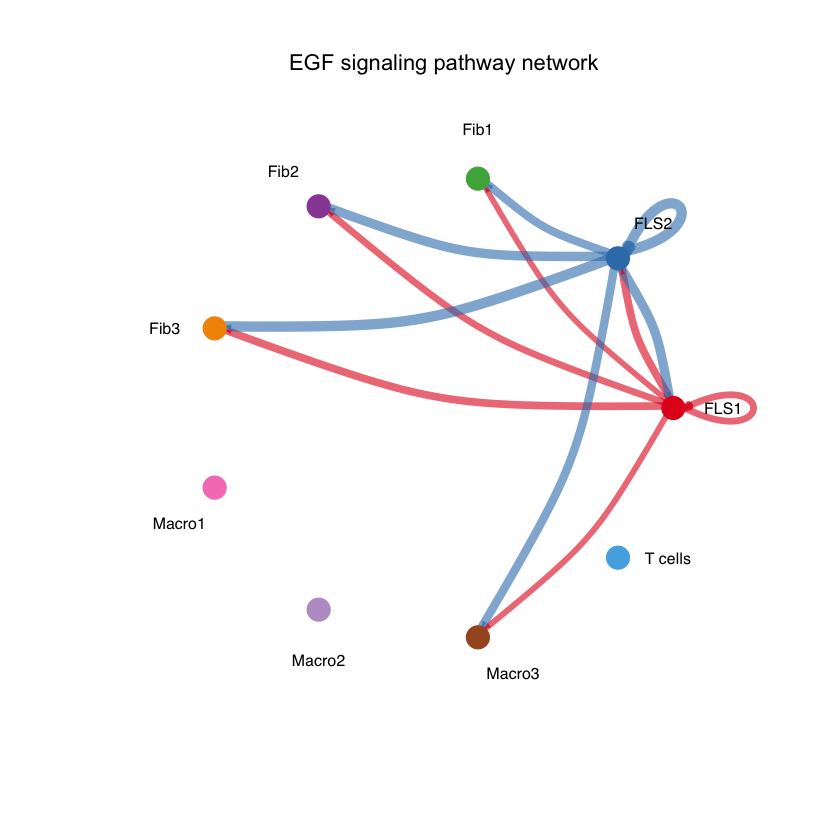

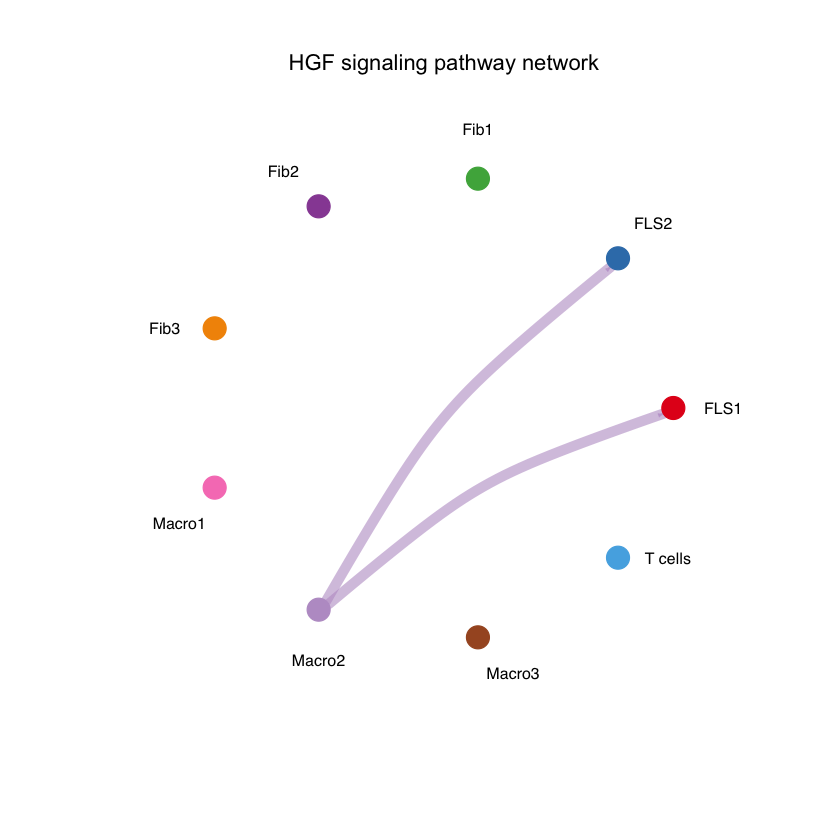

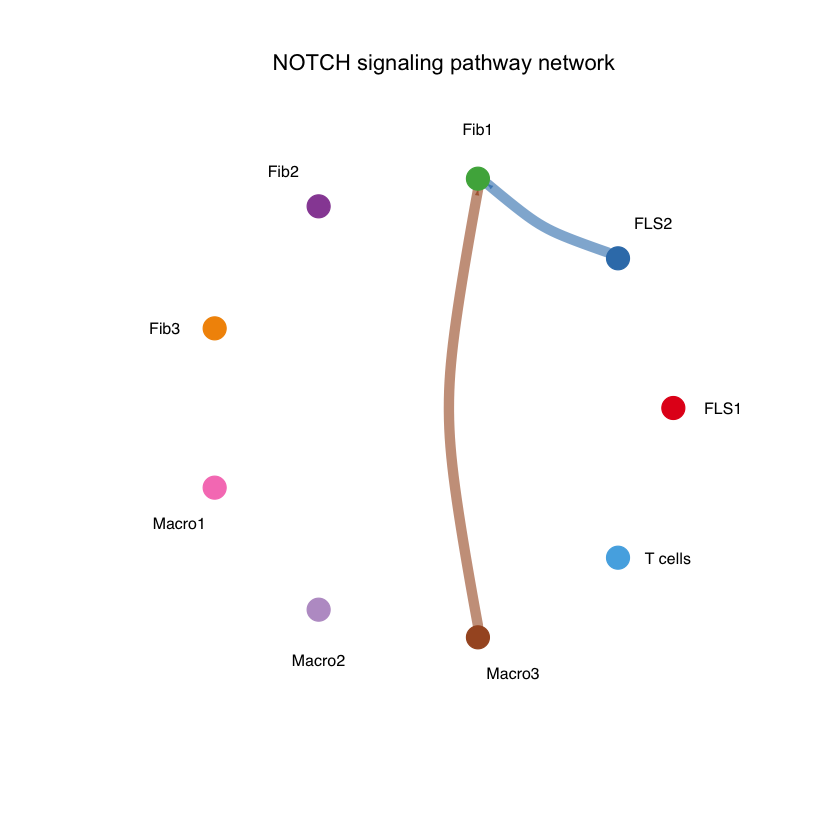

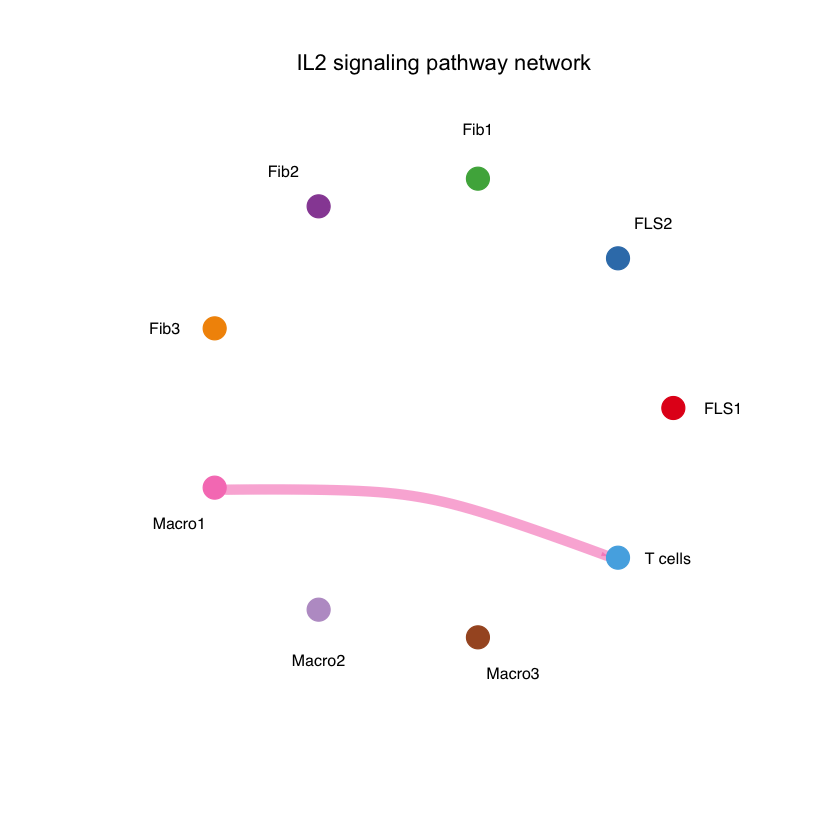

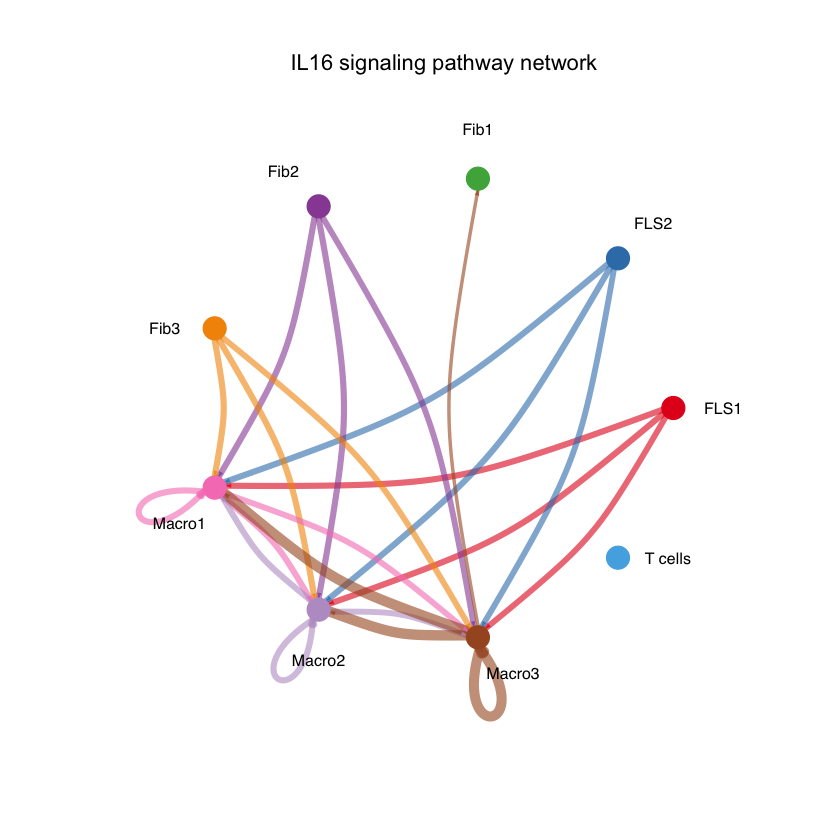

In [25]:
# pathways.show <- cellchat@netP$pathways
pathways.show <- c('COLLAGEN', 'PDGF', 'IGF', 'ncWNT', 'EGF','HGF', 'NOTCH','IL2','IL16')
# Hierarchy plot
# Here we define `vertex.receive` so that the left portion of the hierarchy plot shows signaling to fibroblast and the right portion shows signaling to immune cells 
for (val in pathways.show){
    vertex.receiver = seq(1,4) # a numeric vector. 
    # Circle plot
    par(mfrow=c(1,1))
#     pdf(paste('./figures/cellchat/', val,'_circle.pdf', sep = ''))
    netVisual_aggregate(cellchat, signaling = val, layout = "circle")
#     dev.off()
    }

In [ ]:
for( val in pathways.show){
    pdf(paste('./figures/cellchat/', val,'_chord.pdf', sep = ''), width = 10, height = 10)
    netVisual_aggregate(cellchat, signaling =val, layout = "chord", vertex.label.cex = 01)
    dev.off()
    }

In [ ]:
# val = 'ncWNT'
# pdf(paste('./figures/cellchat/', val,'_heatmap.pdf', sep = ''), width = 10, height = 10)
# #     netVisual_heatmap(cellchat, signaling = val, color.heatmap = "Reds")
# netVisual_heatmap(cellchat, signaling = val, color.heatmap = "Reds")
# dev.off()

In [ ]:
pathways.show <- c('COLLAGEN', 'PDGF', 'IGF', 'ncWNT', 'EGF','HGF', 'NOTCH','IL2','IL16')
for( val in pathways.show){
    pdf(paste('./figures/cellchat/', val,'_heatmap.pdf', sep = ''), width = 10, height = 10)
#     netVisual_heatmap(cellchat, signaling = val, color.heatmap = "Reds")
    print(netVisual_heatmap(cellchat, signaling = val, color.heatmap = "Reds"))
    dev.off()
    }


In [469]:
pdf('./figures/cellchat/contribution.pdf')
netAnalysis_contribution(cellchat, signaling = pathways.show)
dev.off()

pdf 
  2

我们还可以可视化由单个配体-受体对介导的细胞间通讯。我们提供了一个函数extractEnrichedLR来提取给定信号通路的所有重要相互作用（LR 对）和相关信号基因。



In [39]:
pairLR.CXCL <- extractEnrichedLR(cellchat, signaling = pathways.show, geneLR.return = FALSE)
for (val in pathways.show){
    pdf(paste('./figures/cellchat/extract_interaction_of_', val,'_circle.pdf', sep = ''), width = 10,
       height=10)
    netVisual_individual(cellchat, signaling = val,  pairLR.use =pairLR.CXCL)
    dev.off()
    
   
}



# bubble

In [59]:
pdf('./figures/cellchat/bubble_plot.pdf',width = 15,height = 10)
netVisual_bubble(cellchat, remove.isolate = FALSE, title='Bubble plot',signaling = pathways.show)
dev.off()

Comparing communications on a single object 




pdf 
  2

# chord

In [63]:
fib_marker = c('LUM','IGFBP6', 'COL1A1','ASPN', 'FBLN1', 'THY1') # Fibroblasts
macr_marker = c('MS4A6A', 'CD163', 'CD14', 'CYBB', 'CTSS') # Macrophages-m2
fib_syn_marker = c('CLIC5', 'HAS1', 'HBEGF') # Fibroblast-like Synoviocytes
end_marker = c('PTPRB', 'VWF', 'EMCN', 'ADGRL4') # Endothelial Cells
VSMC_marker = c('NOTCH3', 'ACTA2', 'TAGLN', 'TPM2') # Vascular Smooth Muscle Cells
TC_marker = c('CD2', 'CD3D') # T Cells
marker_genes = append(fib_syn_marker, fib_marker , macr_marker , TC_marker, end_marker , VSMC_marker)

ERROR: Error in append(fib_syn_marker, fib_marker, macr_marker, TC_marker, end_marker, : unused arguments (TC_marker, end_marker, VSMC_marker)


In [ ]:
pdf('./figures/cellchat/chord_plot.pdf',width = 20,height = 20)
netVisual_chord_gene(cellchat, signaling = pathways.show,)
dev.off()

In [ ]:
for(val in pathways.show){
    plotGeneExpression(cellchat, signaling =val)
    ggsave(paste('./figures/cellchat/' , val, '_geneExp.pdf', sep = ''))
}
    

In [20]:
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP")

In [23]:
pathways.show <- c('COLLAGEN', 'PDGF', 'IGF', 'ncWNT','TGFb','FGF','CSF','BMP','CXCL')

In [22]:
pathways.show <- c( 'FN1','MIF', 'TENASCIN','THY1','IGF' ,'NOTCH')

In [24]:
cellchat@netP$pathways

[1] "COLLAGEN"   "FN1"        "APP"        "MHC-II"     "CD99"      
 [6] "MIF"        "LAMININ"    "CD45"       "PDGF"       "THBS"      
[11] "TENASCIN"   "CXCL"       "NEGR"       "SEMA3"      "GAS"       
[16] "MK"         "ANGPTL"     "COMPLEMENT" "GALECTIN"   "THY1"      
[21] "PTPRM"      "TGFb"       "FGF"        "ANNEXIN"    "GRN"       
[26] "PECAM1"     "PTN"        "PROS"       "ADGRE5"     "CHEMERIN"  
[31] "MPZ"        "IGF"        "CSF"        "IL16"       "JAM"       
[36] "EPHA"       "ITGB2"      "ICAM"       "VCAM"       "HSPG"      
[41] "BMP"        "NOTCH"      "VISFATIN"   "CADM"       "ncWNT"     
[46] "CD46"       "CCL"        "MHC-I"      "EPHB"

In [24]:
for(val in pathways.show){
    pdf(paste('./figures/cellchat/',val, 'netAnalysis_signalingRole_network—naf.pdf'),width = 5,height = 5)
    netAnalysis_signalingRole_network(cellchat, signaling = val, width = 8, height = 2.5, font.size = 10)
    dev.off()
}


In [75]:
for(val in pathways.show){
#     pdf(paste('./figures/cellchat/',val, 'netAnalysis_signalingRole_scatter.pdf'),width = 5,height = 5)
    gg = netAnalysis_signalingRole_scatter(cellchat, signaling =val)
    ggsave(paste('./figures/cellchat/',val, 'netAnalysis_signalingRole_scatter.pdf'),width = 5,height = 5)
#     dev.off()
}



Signaling role analysis on the cell-cell communication network from user's input

Signaling role analysis on the cell-cell communication network from user's input

Signaling role analysis on the cell-cell communication network from user's input

Signaling role analysis on the cell-cell communication network from user's input

Signaling role analysis on the cell-cell communication network from user's input

Signaling role analysis on the cell-cell communication network from user's input

Signaling role analysis on the cell-cell communication network from user's input

Signaling role analysis on the cell-cell communication network from user's input

Signaling role analysis on the cell-cell communication network from user's input



In [77]:
pdf('./figures/cellchat/outgoing.pdf')
netAnalysis_signalingRole_heatmap(cellchat, pattern = "outgoing",signaling = pathways.show)

dev.off()
pdf('./figures/cellchat/incoming.pdf')
netAnalysis_signalingRole_heatmap(cellchat, pattern = "incoming",signaling = pathways.show)

dev.off()

pdf 
  2

pdf 
  2

In [26]:
# pdf('./figures/cellchat/outgoing.pdf')
# par(mfrow = c(1,2))
# netAnalysis_signalingRole_heatmap(cellchat, pattern = "outgoing")
# netAnalysis_signalingRole_heatmap(cellchat, pattern = "incoming")
# dev.off()

In [63]:
library(NMF)
library(ggalluvial)

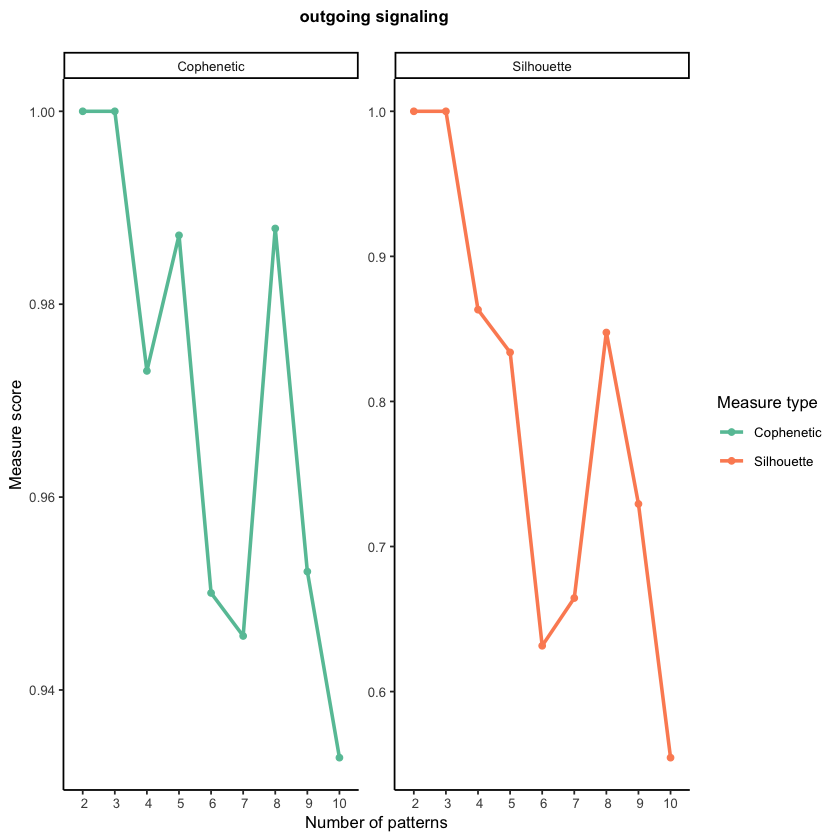

In [64]:
selectK(cellchat, pattern = "outgoing")
ggsave('./figures/cellchat/sk_outgoing.pdf',width = 5,height = 5)

In [66]:
nPatterns = 3
pdf('./figures/cellchat/outgoing-identifyCommunicationPatterns.pdf')
cellchat <- identifyCommunicationPatterns(cellchat, pattern = "outgoing", k = nPatterns)
dev.off()

pdf 
  2

In [67]:
pdf('./figures/cellchat/outgoing_river_plot.pdf')
netAnalysis_river(cellchat, pattern = "outgoing")
dev.off()

Please make sure you have load `library(ggalluvial)` when running this function



pdf 
  2

In [33]:
pdf('./figures/cellchat/outgoing_dot_plot.pdf')
netAnalysis_dot(cellchat, pattern = "outgoing")
dev.off()

pdf 
  2

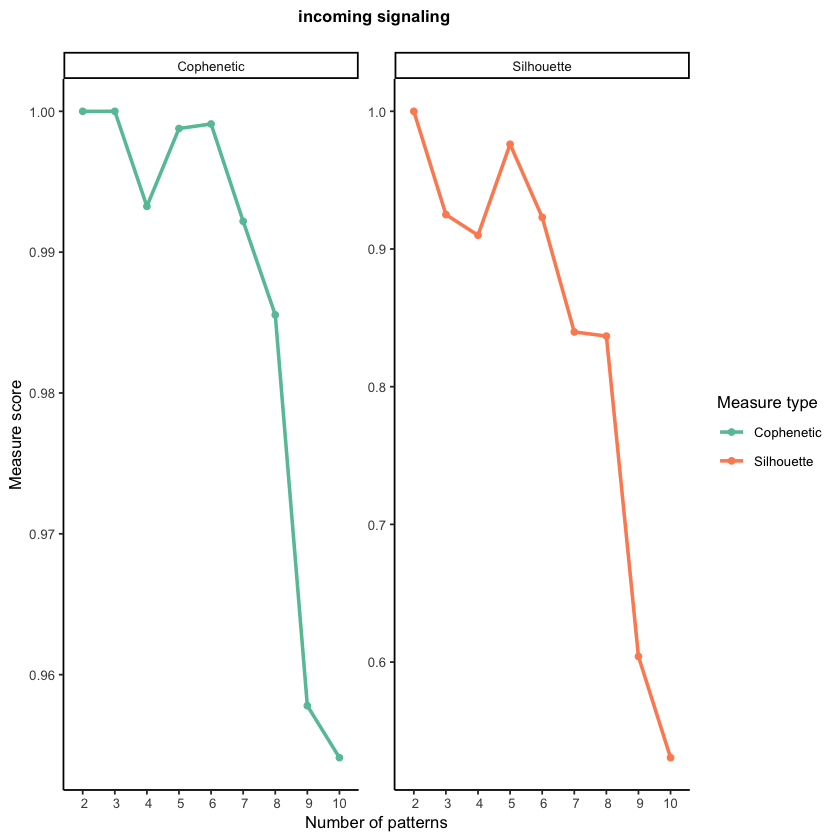

In [65]:
selectK(cellchat, pattern = "incoming")
ggsave('./figures/cellchat/sk_incoming.pdf',width = 5,height = 5)

In [68]:
nPatterns = 3
pdf('./figures/cellchat/imcoming-identifyCommunicationPatterns.pdf')
cellchat <- identifyCommunicationPatterns(cellchat, pattern = "incoming", k = nPatterns)
dev.off()


pdf 
  2

In [69]:
pdf('./figures/cellchat/incoming_river_plot.pdf')
netAnalysis_river(cellchat, pattern = "incoming")
dev.off()

Please make sure you have load `library(ggalluvial)` when running this function



pdf 
  2

In [70]:
pdf('./figures/cellchat/incoming_dot_plot.pdf')
netAnalysis_dot(cellchat, pattern = "incoming")
dev.off()

pdf 
  2

In [71]:
cellchat <- computeNetSimilarity(cellchat, type = "functional")
cellchat <- netEmbedding(cellchat, type = "functional")
#> Manifold learning of the signaling networks for a single dataset
cellchat <- netClustering(cellchat, type = "functional")
#> Classification learning of the signaling networks for a single dataset
# Visualization in 2D-space
pdf('./figures/cellchat/functional.pdf')
netVisual_embedding(cellchat, type = "functional", label.size = 3.5)
dev.off()

Manifold learning of the signaling networks for a single dataset 
Classification learning of the signaling networks for a single dataset 


pdf 
  2

In [72]:
cellchat <- computeNetSimilarity(cellchat, type = "structural")
cellchat <- netEmbedding(cellchat, type = "structural")
#> Manifold learning of the signaling networks for a single dataset
cellchat <- netClustering(cellchat, type = "structural")
#> Classification learning of the signaling networks for a single dataset
# Visualization in 2D-space
pdf('./figures/cellchat/structural.pdf')
netVisual_embedding(cellchat, type = "structural", label.size = 3.5)
dev.off()

Manifold learning of the signaling networks for a single dataset 
Classification learning of the signaling networks for a single dataset 


pdf 
  2

In [73]:
pdf('./figures/cellchat/structural_embeddingZoomIn.pdf')
netVisual_embeddingZoomIn(cellchat, type = "structural", nCol = 2)
dev.off()

pdf 
  2

In [40]:
saveRDS(cellchat, file = "../data/v3.rds")